In [ ]:
# %%

" ai for source separation of percussions in urban sounds"
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import time
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import random
import argparse
import pandas as pd
from tqdm import tqdm
# We have 7358 sounds of differents classes (dog bark, drilling, jackhammer, siren, children_playing, engine idling, air conditioner, car horn) with a duration of maximum 4 seconds some are shorter
# 387 files of the percussions class that we want to separate from the others or "hear" better

n_fft = 256
hop_length = n_fft // 4

In [ ]:
# %%

# where to find the noise
DATASET_NOISE_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\dataset"

metadata_noise = os.path.join(DATASET_NOISE_PATH, "UrbanSound8k.csv")
metadata_noise = pd.read_csv(metadata_noise)
print(metadata_noise['class'].value_counts())

# class
# dog_bark            1000
# children_playing    1000
# air_conditioner     1000
# engine_idling       1000
# jackhammer          1000
# drilling            1000
# siren                929
# car_horn             429
# Name: count, dtype: int64

DATASET_PERCUSSION_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\J.Palmilha\\data"
metadata_perc = os.path.join(DATASET_PERCUSSION_PATH, "metadata.csv")
metadata_perc = pd.read_csv(metadata_perc)

metadata_perc.value_counts()

# Example dataframe for noise classes
noise_data = {
    'class': ['dog_bark', 'children_playing', 'air_conditioner', 'engine_idling',
              'jackhammer', 'drilling', 'siren', 'car_horn'],
    'count': [1000, 1000, 1000, 1000, 1000, 1000, 929, 429]
}
df = pd.DataFrame(noise_data)

# Example paths to noise files (adjust paths according to your setup)
noise_folder = DATASET_NOISE_PATH  # path to the folder containing the noise files

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
Name: count, dtype: int64


In [ ]:
# %%

# Function to create mixture


def create_mixture(percussion_audio, noise_audio):

    percussion_audio /= np.max(np.abs(percussion_audio))
    noise_audio /= np.max(np.abs(noise_audio))

    # Mix audio files
    mixture_audio = percussion_audio + noise_audio

    # Normalize mixture
    mixture_audio /= np.max(np.abs(mixture_audio))

    # Calculate stft
    stft = librosa.stft(mixture_audio, n_fft=n_fft, hop_length=hop_length)

    return mixture_audio, stft


def get_stft(audio):

    # Normalize audio
    audio /= np.max(np.abs(audio))

    # Calculate stft
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

    return stft


def audio_from_spectrogram(mag, phase):
    stft = mag * torch.exp(1j * phase)
    # print(f'stft device', stft.device)
    # audio = librosa.istft(stft, hop_length=hop_length)
    audio = torch.istft(stft, n_fft=n_fft, hop_length=hop_length,
                        length=4 * 7812, window=torch.hann_window(n_fft, device='cuda'))
    return audio

# calculate error reconstruction and original


def calculate_error(original, reconstruction):
    error = torch.abs(original - reconstruction).mean()  # mean absolute
    return error

In [ ]:
# %%

# Total number of percussion files
percussion_count = 387

# Calculate total number of noise files
total_noise_files = df['count'].sum()

# Calculate proportions for each noise class
df['proportion'] = df['count'] / total_noise_files

# every percussion files will get 40 noise files 5 from each class
# this will give us a total number of 387 * 24 = 9288 noise files
# Number of noise files to select for each percussion file
noise_files_per_percussion = 40

# we will save the informations of all the noised used for each percussion file
# save the informations in a csv file : percussion_file, noise_file, noise_class, mixture_file


def pad_audio_center(audio_path):

    # Load audio files
    audio, _ = librosa.load(path=audio_path, sr=7812)

    # Pad audio to have length of 4 seconds
    audio_len = len(audio)
    target_len = 4 * 7812  # 4 seconds at 7812 Hz
    pad_len = target_len - audio_len

    if pad_len > 0:
        pad_left = pad_len // 2
        pad_right = pad_len - pad_left
        audio = np.pad(audio, (pad_left, pad_right), 'constant')
    else:
        audio = audio[:target_len]

    return audio

In [ ]:
# %%

# Create a folder to save mixture audio
DATASET_MIX_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\mixture_audio"

# Create the folder if it does not exist
if not os.path.exists(DATASET_MIX_AUDIO_PATH):
    os.makedirs(DATASET_MIX_AUDIO_PATH)

DATASET_MIX_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\mixture_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_MIX_STFT_PATH):
    os.makedirs(DATASET_MIX_STFT_PATH)

# Create a folder to save percussion stft
DATASET_PERCUSSION_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\percussion_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_PERCUSSION_STFT_PATH):
    os.makedirs(DATASET_PERCUSSION_STFT_PATH)

# Create a folder to save noise stft
DATASET_NOISE_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\noise_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_NOISE_STFT_PATH):
    os.makedirs(DATASET_NOISE_STFT_PATH)

In [ ]:
# %%

"""
# Iterate over each percussion file
for index, row in metadata_perc.iterrows():
    percussion_filename = row['name']
    percussion_file = os.path.join(
        DATASET_PERCUSSION_PATH, percussion_filename)

    # Create a list to store noise information
    sound_info = []

    # Iterate over each noise class
    for _, noise_row in df.iterrows():
        noise_class = noise_row['class']
        noise_count = noise_row['count']
        noise_proportion = noise_row['proportion']

        # Calculate number of noise files to select for this class
        noise_files_to_select = int(
            noise_files_per_percussion * noise_proportion)

        # Randomly select noise files from the current class
        selected_fold = np.random.randint(1, 11)
        noise_files_in_fold = metadata_noise[(metadata_noise['class'] == noise_class) &
                                             (metadata_noise['fold'] == selected_fold)]['slice_file_name'].tolist()

        if len(noise_files_in_fold) > 0:
            selected_noise_files = np.random.choice(
                noise_files_in_fold, noise_files_to_select, replace=False)

            for noise_file_name in selected_noise_files:
                noise_file = os.path.join(DATASET_NOISE_PATH, f"fold{
                                          selected_fold}", noise_file_name)

                # Load audio files
                percussion_audio = pad_audio_center(percussion_file)
                noise_audio = pad_audio_center(noise_file)

                # Calculate stft
                stft_p = get_stft(percussion_audio)
                stft_n = get_stft(noise_audio)

                # create mixture
                mixture_audio, stft_mix = create_mixture(
                    percussion_audio, noise_audio)

                # Save sound information
                sound_info.append({
                    'percussion_file': percussion_filename,
                    'noise_file': noise_file_name,
                    # mixture file name
                    'mix_file': f"{percussion_filename}_{noise_file_name}",
                    'noise_class': noise_class,
                    'fold': selected_fold,
                })

                # Save mixture audio
                mixture_audio_path = os.path.join(
                    DATASET_MIX_AUDIO_PATH, f"{percussion_filename}_{noise_file_name}.wav")
                sf.write(mixture_audio_path, mixture_audio, 7812)

                # Save mixture stft
                mix_stft_path = os.path.join(
                    DATASET_MIX_STFT_PATH, f"{percussion_filename}_{noise_file_name}.npy")
                np.save(mix_stft_path, stft_mix)

                # Save noise stft
                noise_stft_path = os.path.join(
                    DATASET_NOISE_STFT_PATH, f"{noise_file_name}.npy")
                np.save(noise_stft_path, stft_n)

                # Save percussion stft
                percussion_stft_path = os.path.join(
                    DATASET_PERCUSSION_STFT_PATH, f"{percussion_filename}.npy")
                np.save(percussion_stft_path, stft_p)

    # Save sound information to a csv file
    sound_info = pd.DataFrame(sound_info)
    sound_info.to_csv(os.path.join(
        DATASET_MIX_AUDIO_PATH, f"{percussion_filename}_info.csv"), index=False)"""

'\n# Iterate over each percussion file\nfor index, row in metadata_perc.iterrows():\n    percussion_filename = row[\'name\']\n    percussion_file = os.path.join(\n        DATASET_PERCUSSION_PATH, percussion_filename)\n\n    # Create a list to store noise information\n    sound_info = []\n\n    # Iterate over each noise class\n    for _, noise_row in df.iterrows():\n        noise_class = noise_row[\'class\']\n        noise_count = noise_row[\'count\']\n        noise_proportion = noise_row[\'proportion\']\n\n        # Calculate number of noise files to select for this class\n        noise_files_to_select = int(\n            noise_files_per_percussion * noise_proportion)\n\n        # Randomly select noise files from the current class\n        selected_fold = np.random.randint(1, 11)\n        noise_files_in_fold = metadata_noise[(metadata_noise[\'class\'] == noise_class) &\n                                             (metadata_noise[\'fold\'] == selected_fold)][\'slice_file_name\'].tolist

In [ ]:
# %%

# We have the 387 metadata files (same number of percussion)

# we should save the metadata into a single metadata file
# we can use this metadata file to load the data into the dataset class
# we can also use it to split the data into training, validation and test sets
# we can also use it to load only the noise files of a specific class

"""metadata_info = []

for index, row in metadata_perc.iterrows():
    percussion_filename = row['name']
    sound_info = pd.read_csv(os.path.join(
        DATASET_MIX_AUDIO_PATH, f"{percussion_filename}_info.csv"))
    metadata_info.append(sound_info)

metadata_info = pd.concat(metadata_info)
metadata_info.to_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"), index=False)"""

'metadata_info = []\n\nfor index, row in metadata_perc.iterrows():\n    percussion_filename = row[\'name\']\n    sound_info = pd.read_csv(os.path.join(\n        DATASET_MIX_AUDIO_PATH, f"{percussion_filename}_info.csv"))\n    metadata_info.append(sound_info)\n\nmetadata_info = pd.concat(metadata_info)\nmetadata_info.to_csv(os.path.join(\n    DATASET_MIX_AUDIO_PATH, "metadata.csv"), index=False)'

In [ ]:
# %%

# Define the dataset class


class MixtureDataset(Dataset):
    # noise class is a string maybe
    def __init__(self, metadata_file, transform=None, noise_class=None):
        self.metadata = metadata_file
        # since we have multiple classes of noise we can choose one to train the model... we can also train the model with all the classes
        # we can use it to load only the noise files of a specific class
        self.noise_class = noise_class
        self.transform = transform

    def __len__(self):
        # get the row with only the noise class we want
        if self.noise_class:
            return len(self.metadata[self.metadata['noise_class'] == self.noise_class])

    def __getitem__(self, idx):
        # get the row with only the noise class we want
        if self.noise_class:
            row = self.metadata[self.metadata['noise_class']
                                == self.noise_class].iloc[idx]

            # Load mixture audio and percussion audio
            mixture_audio = librosa.load(os.path.join(
                DATASET_MIX_AUDIO_PATH, f"{row['mix_file']}.wav"), sr=7812)[0]

            percussion_audio = pad_audio_center(os.path.join(
                DATASET_PERCUSSION_PATH, row['percussion_file']))
            percussion_audio /= np.max(np.abs(percussion_audio))

            # Load mixture stft
            mixture_stft = np.load(os.path.join(
                DATASET_MIX_STFT_PATH, f"{row['mix_file']}.npy"))
            mixture_stft = torch.tensor(
                mixture_stft, requires_grad=True, dtype=torch.complex64)

            # Load noise stft
            # noise_stft = np.load(os.path.join(
            #     DATASET_NOISE_STFT_PATH, f"{row['noise_file']}.npy"))
            # noise_stft = torch.tensor(
            #     noise_stft, requires_grad=True, dtype=torch.complex64)

            # Load percussion stft
            percussion_stft = np.load(os.path.join(
                DATASET_PERCUSSION_STFT_PATH, f"{row['percussion_file']}.npy"))
            percussion_stft = torch.tensor(
                percussion_stft, requires_grad=True, dtype=torch.complex64)

            # if self.transform:
            #     mix_mag, mix_phase = transform(mixture_stft)
            #     noise_mag, noise_phase = transform(noise_stft)
            #     percussion_mag, percussion_phase = transform(percussion_stft)

            #     return {
            #         'mixture_audio': mixture_audio,
            #         'mixture_stft': mixture_stft,
            #         'mixture_mag': mix_mag,
            #         'mixture_phase': mix_phase,

            #         'noise_mag': noise_mag,
            #         'noise_phase': noise_phase,

            #         'percussion_audio': percussion_audio,
            #         'percussion_mag': percussion_mag,
            #         'percussion_phase': percussion_phase,
            #         'percussion_stft': percussion_stft
            #     }

            return {
                'mixture_audio': mixture_audio,
                'mixture_stft': mixture_stft,

                # 'noise_stft': noise_stft,

                'percussion_audio': percussion_audio,
                'percussion_stft': percussion_stft
            }

# transform function, get the magnitude and phase of the stft


def transform(stft): return (torch.abs(stft), torch.angle(stft))

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

dataset = MixtureDataset(metadata_file=metadata,
                         noise_class='dog_bark', transform=None)

# Split the dataset into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# %%

# test the dataloader
data = next(iter(train_loader))
print(data.keys())

for keys in data.keys():
    print(keys, data[keys].shape)

dict_keys(['mixture_audio', 'mixture_stft', 'percussion_audio', 'percussion_stft'])
mixture_audio torch.Size([16, 31248])
mixture_stft torch.Size([16, 129, 489])
percussion_audio torch.Size([16, 31248])
percussion_stft torch.Size([16, 129, 489])


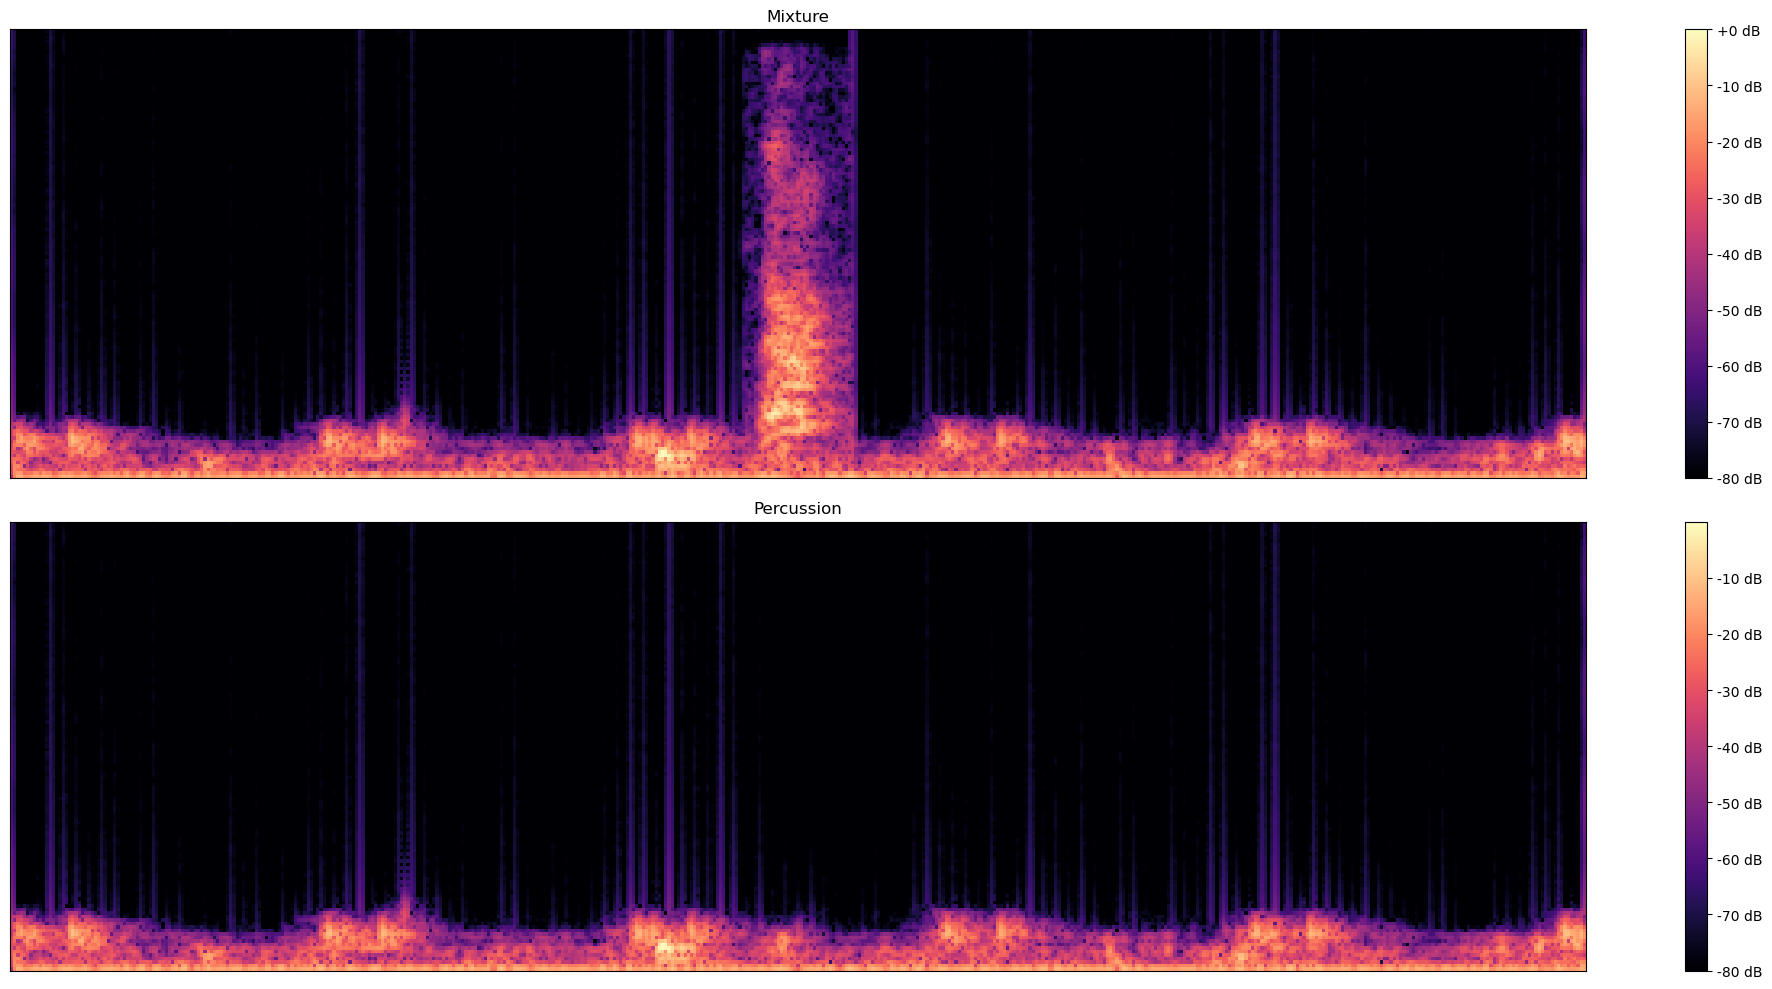

In [ ]:
# %%

# randomly select an index
i = random.randint(0, len(data['mixture_stft']) - 1)

# plot the mixture, percussion
mixture_stft = data['mixture_stft'][i]
percussion_stft = data['percussion_stft'][i]
# noise_stft = data['noise_stft'][i]

# Convert the mixture to numpy
mixture_stft = mixture_stft.cpu().detach().numpy()

# Convert the target to numpy
percussion_stft = percussion_stft.cpu().detach().numpy()

# Convert the noise to numpy
# noise_stft = noise_stft.cpu().detach().numpy()

# Plot the mixture and percussion stft
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.title("Mixture")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(mixture_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 1, 2)
plt.title("Percussion")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(percussion_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

# plt.subplot(3, 1, 3)
# plt.title("Noise")
# librosa.display.specshow(librosa.amplitude_to_db(
#     np.abs(noise_stft), ref=np.max), sr=7812, hop_length=hop_length)
# plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
# %%

"""
# randomly select an index
i = random.randint(0, len(data['mixture_mag']) - 1)

# plot the mixture, percussion
mixture_mag = data['mixture_mag'][i]
percussion_mag = data['percussion_mag'][i]
noise_mag = data['noise_mag'][i]

# Convert the mixture to numpy
mixture_mag = mixture_mag.cpu().detach().numpy()

# Convert the target to numpy
percussion_mag = percussion_mag.cpu().detach().numpy()

# Convert the noise to numpy
noise_mag = noise_mag.cpu().detach().numpy()

# Plot the mixture and percussion stft
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.title("Mixture")
librosa.display.specshow(librosa.amplitude_to_db(
    mixture_mag, ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 2)
plt.title("Percussion")
librosa.display.specshow(librosa.amplitude_to_db(
    percussion_mag, ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 3)
plt.title("Noise")
librosa.display.specshow(librosa.amplitude_to_db(
    noise_mag, ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()"""

'\n# randomly select an index\ni = random.randint(0, len(data[\'mixture_mag\']) - 1)\n\n# plot the mixture, percussion\nmixture_mag = data[\'mixture_mag\'][i]\npercussion_mag = data[\'percussion_mag\'][i]\nnoise_mag = data[\'noise_mag\'][i]\n\n# Convert the mixture to numpy\nmixture_mag = mixture_mag.cpu().detach().numpy()\n\n# Convert the target to numpy\npercussion_mag = percussion_mag.cpu().detach().numpy()\n\n# Convert the noise to numpy\nnoise_mag = noise_mag.cpu().detach().numpy()\n\n# Plot the mixture and percussion stft\nplt.figure(figsize=(20, 10))\nplt.subplot(3, 1, 1)\nplt.title("Mixture")\nlibrosa.display.specshow(librosa.amplitude_to_db(\n    mixture_mag, ref=np.max), sr=7812, hop_length=hop_length)\nplt.colorbar(format=\'%+2.0f dB\')\n\nplt.subplot(3, 1, 2)\nplt.title("Percussion")\nlibrosa.display.specshow(librosa.amplitude_to_db(\n    percussion_mag, ref=np.max), sr=7812, hop_length=hop_length)\nplt.colorbar(format=\'%+2.0f dB\')\n\nplt.subplot(3, 1, 3)\nplt.title("Nois

In [ ]:
# %%

# Define the model

# Evaluation metrics will be : signal-to-distortion ratio improvement SDRi and signal-to-distortion ratio improvement.
# activate torch cudnn
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


class SeparationModel(nn.Module):
    def __init__(self):
        super(SeparationModel, self).__init__()
        """
        Define the model architecture
            It's a resunet model
            The input will be the mixture stft the encoder decoder will process the magnitude spectrogram
            3 encoder blocks 2 bottleneck blocks and 3 decoder blocks.

            In each encoder block, the spectrogram is downsampled into a bottleneck feature using 4 residual convolutional blocks,
            while each decoder block utilizes 4 residual deconvolutional blocks to upsample the feature and obtain the separation components.
            A skip connection is established between each encoder block and the corresponding decoder block, operating at the same downsampling/upsampling rate.
            The residual block consists of 2 CNN layers, 2 batch normalization layers, and 2 Leaky-ReLU activation layers.
            Furthermore, we introduce an additional residual shortcut connecting the input and output of each residual block.
            The ResUNet model inputs the complex spectrogram X and outputs the magnitude mask |M| and the phase residual ∠M conditioned on the text embedding eq.
            |M| controls how much the magnitude of |X| should be scaled, and the angle ∠M controls how much the angle of ∠X should be rotated.
            The separated complex spectrogram can be obtained by multiplying the STFT of the mixture and the predicted magnitude mask |M| and phase residual ∠X:
            Y = |M| ⊙ |X|exp(j(∠X + ∠M)), where ⊙ denotes Hadamard product.
        """

        self.encoder1 = nn.Sequential(
            # 2 channels for the magnitude and phase
            nn.Conv2d(2, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.output = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # to get the mask
        )

    def forward(self, x):

        # print(f'input shape: {x.shape}')

        # add the channel dimension torch.size([16, 1, 129, 489])
        x = x.unsqueeze(1)
        # we want  torch.size([16, 2, 129, 489]) first channel is the magnitude and the second is the phase
        # so when we do output = model(mixture_stft) we get the magnitude and phase of the output in
        x = torch.cat((torch.abs(x), torch.angle(x)), dim=1)
        # print(f'input shape after cat: {x.shape}')
        # print(x)
        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)

        # Bottleneck
        b = self.bottleneck(x3)

        # Decoder
        d1 = self.decoder1(b)
        d2 = self.decoder2(d1)
        d3 = self.decoder3(d2)

        # Output
        out = self.output(d3)

        # out shape: torch.Size([4, 1, 136, 496]) our input is torch.Size([4, 1, 129, 489]) so we have to resize the output to match the input
        # print(f'out shape after Conv2d from output: {out.shape}')

        # resize the output to match the input
        out = F.interpolate(out, size=(129, 489),
                            mode='bilinear', align_corners=False)
        # print(f'out shape after interpolate: {out.shape}')
        return out

In [ ]:
# %%

# define the metrics


# def calculate_sdr(target, prediction):
#     # Calculate the signal-to-distortion ratio
#     target_power = torch.sum(target**2)
#     error_power = torch.sum((target - prediction)**2)
#     sdr = 10 * torch.log10(target_power / error_power)
#     return sdr

def calculate_sdr_improvement(target, prediction, mixture):
    """
        Compute the signal-to-distortion ratio improvement

    Args:
        target (_type_): true percussion signal
        prediction (_type_): predicted percussion signal
        mixture (_type_): mixture of the percussion and noise signals

    Returns:
        _type_: signal-to-distortion ratio improvement
    """
    # Calculate the signal-to-distortion ratio improvement
    target_power = torch.sum(target**2)  # target is the percussion
    error_power = torch.sum((target - prediction)**2)
    mixture_power = torch.sum(mixture**2)
    sdr = 10 * torch.log10(target_power / error_power)
    sdr_mixture = 10 * torch.log10(target_power / mixture_power)
    sdr_i = sdr - sdr_mixture
    return sdr_i


# define the loss function


def loss_function(prediction, target):
    # spectral loss
    # log magnitude spectrogram loss
    # target is the percussion target_stft we take the magnitude of the target hence the abs
    # prediction is the predicted percussion stft
    # ||log(abs(target) + 1e-9) - log(abs(prediction) + 1e-9)||_L1, L1 norm

    # Calculate the log magnitude spectrogram loss

    target_stft = torch.log(torch.abs(target) + 1e-9)
    prediction_stft = torch.log(torch.abs(prediction) + 1e-9)
    loss = F.l1_loss(target_stft, prediction_stft)

    return loss

In [ ]:
# %%

# Define the training function


def train(model, train_loader, val_loader, num_epochs, optimizer, criterion, device):
    # Move model to device
    model.to(device)

    # Initialize the best validation loss
    best_val_loss = float('inf')

    # Initialize lists to store losses and accuracies
    train_losses = []
    val_losses = []

    # Train the model
    for epoch in range(num_epochs):
        start_time = time.time()

        # Set model to training mode
        model.train()

        # Initialize variables to store loss and accuracy
        train_loss = 0.0

        # Initialize tqdm progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {
                         epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}")

        # Iterate over the training data
        for i, data in enumerate(train_bar):

            mixture_stft = data['mixture_stft'].to(device)
            percussion_stft = data['percussion_stft'].to(device)

            # using the magnitude and phase
            # mixture_mag = data['mixture_mag'].to(device)
            # mixture_phase = data['mixture_phase'].to(device)

            # percussion_mag = data['percussion_mag'].to(device)
            # percussion_phase = data['percussion_phase'].to(device)

            # Forward pass
            mask = model(mixture_stft)

            # print(f'mask shape: {mask.shape}') # mask shape: torch.Size([16, 1, 129, 489])

            # print(f'mixture_stft shape: {mixture_stft.shape}') # mixture_stft shape: torch.Size([16, 129, 489])

            # 16 is the batch size to use the mask we have to multiply it with the mixture_stft the predicted stft should have shape torch.Size([16, 129, 489])

            # Calculate the output (prediction)
            # predicted_stft = mask * mixture_stft it gives us torch.Size([16, 16, 129, 489]) so it's incorrect
            predicted_stft = mask[:, 0, :, :] * mixture_stft
            # print(f'predicted_stft shape: {predicted_stft.shape}') # predicted_stft shape: torch.Size([16, 129, 489])

            # # Convert the output to complex
            # predicted_stft = predicted_magnitude * \
            #     torch.exp(1j * predicted_phase)

            # Calculate the loss
            loss = criterion(predicted_stft, percussion_stft)

            # Zero the gradients
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

            # Update the training loss
            train_loss += loss.item()

            # Update the tqdm progress bar description
            train_bar.set_description(
                f"Epoch {epoch + 1}/{num_epochs}, Average training Loss: {train_loss / (i + 1):.4f}")

        # Calculate the average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Set model to evaluation mode
        model.eval()

        # Initialize variables to store loss and accuracy
        val_loss = 0.0

        SDRi_list = []

        # Disable gradient computation
        with torch.no_grad():
            # Initialize tqdm progress bar
            val_bar = tqdm(val_loader, desc=f"Epoch {
                           epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

            # Iterate over the validation data
            for i, data in enumerate(val_bar):
                # mixture_stft = data['mixture_stft'].to(device)
                percussion_true = data['percussion_audio'].to(device)
                percussion_stft = data['percussion_stft'].to(device)

                # using the magnitude and phase
                mixture_true = data['mixture_audio'].to(device)
                mixture_stft = data['mixture_stft'].to(device)
                # mixture_mag = data['mixture_mag'].to(device)
                # mixture_phase = data['mixture_phase'].to(device)

                # Forward pass
                # magnitude_mask = model(mixture_mag)
                # phase_residual = model(mixture_phase)

                mask = model(mixture_stft)

                # Calculate the output (prediction)
                # predicted_magnitude = magnitude_mask * mixture_mag
                # predicted_phase = phase_residual + mixture_phase

                predicted_stft = mask[:, 0, :, :] * mixture_stft

                # Convert the output to complex
                # predicted_stft = predicted_magnitude * \
                #     torch.exp(1j * predicted_phase)

                # Calculate the loss
                loss = criterion(predicted_stft, percussion_stft)

                # Update the validation loss
                val_loss += loss.item()

                # we have to predict for each files in the batch : we have to iterate over the batch
                # first we have to convert the predicted stft to audio
                # then we have to calculate the sdr improvement
                # we have to store the sdr improvement in a list

                for i in range(len(predicted_stft)):

                    # take the magnitude and phase
                    predicted_mag = torch.abs(predicted_stft)
                    predicted_phase = torch.angle(predicted_stft)

                    # Convert the output to audio
                    predicted_audio = audio_from_spectrogram(
                        predicted_mag, predicted_phase)

                    print(f'predicted_audio shape: {predicted_audio.shape}')

                    print('\n')

                    print(f'percussion_audio shape: {percussion_true.shape}')

                    # Calculate the signal-to-distortion ratio improvement
                    sdr_i = calculate_sdr_improvement(
                        percussion_true, predicted_audio, mixture_true)
                    SDRi_list.append(sdr_i)

                # Update the tqdm progress bar description
                val_bar.set_description(
                    f"Epoch {epoch + 1}/{num_epochs}, Average validation Loss: {val_loss / (i + 1):.4f}")

        # print(f"SDRi: {torch.mean(torch.tensor(SDRi_list))}")

        # Calculate the average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")

        # Print the epoch statistics
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {
              train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {time.time() - start_time:.2f}s")

    return train_losses, val_losses, SDRi_list


# Define the model, optimizer and loss function
model = SeparationModel()
# optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-6, amsgrad=True)
optimizer = optim.SGD(model.parameters(), lr=0.001,
                      momentum=0.9, nesterov=True)
criterion = loss_function

# Train the model
train_losses, val_losses, SDRi_list = train(model, train_loader, val_loader,
                                            num_epochs=10, optimizer=optimizer, criterion=criterion, device='cuda')

Epoch 1/10, Average validation Loss: 0.2489:  15%|█▌        | 2/13 [00:00<00:01,  8.26it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 1/10, Average validation Loss: 0.4764:  31%|███       | 4/13 [00:00<00:01,  8.15it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 1/10, Average validation Loss: 0.6697:  46%|████▌     | 6/13 [00:00<00:00,  7.82it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 1/10, Average validation Loss: 0.8933:  62%|██████▏   | 8/13 [00:01<00:00,  7.85it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 1/10, Average validation Loss: 1.1025:  77%|███████▋  | 10/13 [00:01<00:00,  8.36it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 1/10, Average validation Loss: 1.3296:  92%|█████████▏| 12/13 [00:01<00:00,  8.44it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 1/10, Average validation Loss: 23.5538: 100%|██████████| 13/13 [00:01<00:00,  7.95it/s]


predicted_audio shape: torch.Size([1, 31248])


percussion_audio shape: torch.Size([1, 31248])
Epoch 1/10, Training Loss: 1.7723, Validation Loss: 1.8118, Time: 17.69s


Epoch 2/10, Average validation Loss: 0.2465:  15%|█▌        | 2/13 [00:00<00:01,  9.74it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 2/10, Average validation Loss: 0.4721:  31%|███       | 4/13 [00:00<00:00,  9.29it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 2/10, Average validation Loss: 0.6626:  46%|████▌     | 6/13 [00:00<00:00,  8.64it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 2/10, Average validation Loss: 0.8830:  62%|██████▏   | 8/13 [00:00<00:00,  8.77it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 2/10, Average validation Loss: 1.0897:  77%|███████▋  | 10/13 [00:01<00:00,  8.27it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 2/10, Average validation Loss: 23.2689: 100%|██████████| 13/13 [00:01<00:00,  9.54it/s]


predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 3/10, Average validation Loss: 0.2098:  15%|█▌        | 2/13 [00:00<00:01,  9.57it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 3/10, Average validation Loss: 0.4069:  31%|███       | 4/13 [00:00<00:01,  8.85it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 3/10, Average validation Loss: 0.5692:  46%|████▌     | 6/13 [00:00<00:00,  8.91it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 3/10, Average validation Loss: 0.7574:  62%|██████▏   | 8/13 [00:00<00:00,  8.42it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 3/10, Average validation Loss: 0.9361:  77%|███████▋  | 10/13 [00:01<00:00,  8.69it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 3/10, Average validation Loss: 19.6894: 100%|██████████| 13/13 [00:01<00:00,  9.45it/s]


predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 4/10, Average validation Loss: 0.1813:  15%|█▌        | 2/13 [00:00<00:01, 10.15it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 4/10, Average validation Loss: 0.3573:  31%|███       | 4/13 [00:00<00:00,  9.17it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 4/10, Average validation Loss: 0.4949:  46%|████▌     | 6/13 [00:00<00:00,  9.53it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 4/10, Average validation Loss: 0.6540:  62%|██████▏   | 8/13 [00:00<00:00,  9.55it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 4/10, Average validation Loss: 0.8116:  77%|███████▋  | 10/13 [00:01<00:00,  9.40it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 4/10, Average validation Loss: 16.8208: 100%|██████████| 13/13 [00:01<00:00,  9.92it/s]


predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 5/10, Average validation Loss: 0.1711:  15%|█▌        | 2/13 [00:00<00:01,  9.02it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 5/10, Average validation Loss: 0.3372:  31%|███       | 4/13 [00:00<00:01,  9.00it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 5/10, Average validation Loss: 0.4671:  46%|████▌     | 6/13 [00:00<00:00,  9.12it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 5/10, Average validation Loss: 0.6184:  62%|██████▏   | 8/13 [00:00<00:00,  9.29it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 5/10, Average validation Loss: 0.7649:  77%|███████▋  | 10/13 [00:01<00:00,  9.28it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 5/10, Average validation Loss: 15.9678: 100%|██████████| 13/13 [00:01<00:00,  9.67it/s]


predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 6/10, Average validation Loss: 0.1719:   8%|▊         | 1/13 [00:00<00:01,  8.47it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 6/10, Average validation Loss: 0.3360:  31%|███       | 4/13 [00:00<00:00,  9.36it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 6/10, Average validation Loss: 0.4669:  46%|████▌     | 6/13 [00:00<00:00,  9.25it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 6/10, Average validation Loss: 0.6239:  62%|██████▏   | 8/13 [00:00<00:00,  8.62it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 6/10, Average validation Loss: 0.7701:  77%|███████▋  | 10/13 [00:01<00:00,  8.47it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 6/10, Average validation Loss: 16.4851: 100%|██████████| 13/13 [00:01<00:00,  9.57it/s]


predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 7/10, Average validation Loss: 0.2538:  15%|█▌        | 2/13 [00:00<00:01, 10.99it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 7/10, Average validation Loss: 0.4444:  31%|███       | 4/13 [00:00<00:00, 11.06it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 7/10, Average validation Loss: 0.5892:  62%|██████▏   | 8/13 [00:00<00:00, 10.47it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 7/10, Average validation Loss: 0.8148:  77%|███████▋  | 10/13 [00:01<00:00, 10.53it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 7/10, Average validation Loss: 15.4139: 100%|██████████| 13/13 [00:01<00:00, 11.46it/s]


predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 8/10, Average validation Loss: 0.2556:  15%|█▌        | 2/13 [00:00<00:00, 11.30it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 8/10, Average validation Loss: 0.3827:  31%|███       | 4/13 [00:00<00:00, 11.11it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 8/10, Average validation Loss: 0.5878:  62%|██████▏   | 8/13 [00:00<00:00, 10.94it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 8/10, Average validation Loss: 0.7278:  77%|███████▋  | 10/13 [00:00<00:00, 10.38it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 8/10, Average validation Loss: 15.7686: 100%|██████████| 13/13 [00:01<00:00, 11.34it/s]


predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 9/10, Average validation Loss: 0.1579:  15%|█▌        | 2/13 [00:00<00:01,  9.51it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 9/10, Average validation Loss: 0.3139:  31%|███       | 4/13 [00:00<00:00,  9.22it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 9/10, Average validation Loss: 0.4319:  46%|████▌     | 6/13 [00:00<00:00,  8.97it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 9/10, Average validation Loss: 0.5716:  62%|██████▏   | 8/13 [00:00<00:00,  8.99it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 9/10, Average validation Loss: 0.7132:  77%|███████▋  | 10/13 [00:01<00:00,  9.12it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 9/10, Average validation Loss: 15.1257: 100%|██████████| 13/13 [00:01<00:00,  9.66it/s]


predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 10/10, Average validation Loss: 0.1567:  15%|█▌        | 2/13 [00:00<00:01,  9.23it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 10/10, Average validation Loss: 0.3089:  31%|███       | 4/13 [00:00<00:00,  9.34it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 10/10, Average validation Loss: 0.4259:  46%|████▌     | 6/13 [00:00<00:00,  9.16it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 10/10, Average validation Loss: 0.5649:  62%|██████▏   | 8/13 [00:00<00:00,  8.70it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 10/10, Average validation Loss: 0.7017:  77%|███████▋  | 10/13 [00:01<00:00,  9.05it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

Epoch 10/10, Average validation Loss: 15.1369: 100%|██████████| 13/13 [00:01<00:00,  9.77it/s]

predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.Size([16, 31248])


percussion_audio shape: torch.Size([16, 31248])
predicted_audio shape: torch.S

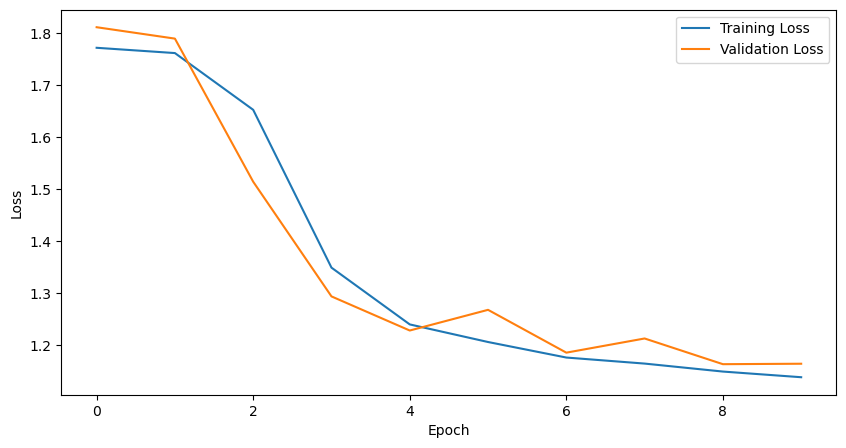

In [ ]:
# %%

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# %%

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):

            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)

            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

<ipython-input-23-6ba95ead36ea>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 7.4012: 100%|██████████| 1

Test Loss: 1.1386
Average SDRi: 6.157279968261719


SDRi list: [tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(6.7006, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.1616, device='cuda:0'), tensor(5.161

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)
    
# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):

            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)

            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i]}_predicted.wav")
            sf.write(predicted_audio_path, predicted_audio.cpu(), 7812)

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

<ipython-input-35-84ce3600c961>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 0.0000:   0%|          | 

LibsndfileError: Error opening 'C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio\\data_2024_03_13-15_34_09.wav_predicted.wav': Format not recognised.

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)
    
# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):

            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)

            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i].split('.')[0]}_predicted.wav")
            sf.write(predicted_audio_path, predicted_audio.cpu(), 7812)

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

<ipython-input-36-47cec84e3979>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 0.0000:   0%|          | 

LibsndfileError: Error opening 'C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio\\data_2024_03_13-15_34_09_predicted.wav': Format not recognised.

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):

            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)

            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i].split('.')[0]}_predicted")
            sf.write(predicted_audio_path, predicted_audio.cpu(), 7812, format='WAV')

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

<ipython-input-37-cc60ab5f6143>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 0.0000:   0%|          | 

LibsndfileError: Error opening 'C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio\\data_2024_03_13-15_34_09_predicted': Format not recognised.

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):

            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)
            print(f'predicted_audio shape: {predicted_audio.shape}')
            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i].split('.')[0]}_predicted")
            sf.write(predicted_audio_path, predicted_audio.cpu(), 7812, format='WAV')

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

<ipython-input-38-b6d6d2d46d03>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 0.0000:   0%|          | 

predicted_audio shape: torch.Size([16, 31248])


LibsndfileError: Error opening 'C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio\\data_2024_03_13-15_34_09_predicted': Format not recognised.

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):

            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)
            
            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i].split('.')[0]}_predicted")
            for i in range(len(predicted_audio)):
                sf.write(predicted_audio_path, predicted_audio[i], 7812)

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

<ipython-input-39-da3995735c7c>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 0.0000:   0%|          | 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):

            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)
            
            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i].split('.')[0]}_predicted")
            for i in range(len(predicted_audio)):
                sf.write(predicted_audio_path, predicted_audio[i].cpu(), 7812)

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

<ipython-input-40-18d76080e60b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 0.0000:   0%|          | 

TypeError: No format specified and unable to get format from file extension: 'C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio\\data_2024_03_13-15_34_09_predicted'

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):

            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)
            
            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i].split('.')[0]}_predicted.wav")
            for i in range(len(predicted_audio)):
                sf.write(predicted_audio_path, predicted_audio[i].cpu(), 7812)

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

<ipython-input-41-ec3273e49899>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 7.6056: 100%|██████████| 

Test Loss: 1.1701
Average SDRi: 5.158052921295166


SDRi list: [tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.152

In [ ]:
#%%

# Print the test loss
print(f"Test Loss: {test_loss:.4f}")

# Print the average signal-to-distortion ratio improvement
print(f"Average SDRi: {torch.mean(torch.tensor(SDRi_list))}")

print('\n')

print(f"SDRi list: {SDRi_list}")

print(f'len SDRi list: {len(SDRi_list)}')

Test Loss: 1.1701
Average SDRi: 5.158052921295166


SDRi list: [tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(4.2957, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.1527, device='cuda:0'), tensor(6.152

In [ ]:
# %%

DATASET_PREDICTED_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\predicted_audio"
if not os.path.exists(DATASET_PREDICTED_AUDIO_PATH):
    os.makedirs(DATASET_PREDICTED_AUDIO_PATH)

# Load the best model
device = 'cuda'
model = SeparationModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model on the test set
test_loss = 0.0

# Initialize a list to store the signal-to-distortion ratio improvement
SDRi_list = []

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar
    test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}")

    # Iterate over the test data
    for i, data in enumerate(test_bar):
        # mixture_stft = data['mixture_stft'].to(device)
        percussion_true = data['percussion_audio'].to(device)
        percussion_name = data['percussion_name']
        percussion_stft = data['percussion_stft'].to(device)

        # using the magnitude and phase
        mixture_true = data['mixture_audio'].to(device)
        mixture_stft = data['mixture_stft'].to(device)
        # mixture_mag = data['mixture_mag'].to(device)
        # mixture_phase = data['mixture_phase'].to(device)

        # Forward pass
        # magnitude_mask = model(mixture_mag)
        # phase_residual = model(mixture_phase)

        mask = model(mixture_stft)

        # Calculate the output (prediction)
        # predicted_magnitude = magnitude_mask * mixture_mag
        # predicted_phase = phase_residual + mixture_phase

        predicted_stft = mask[:, 0, :, :] * mixture_stft

        # Convert the output to complex
        # predicted_stft = predicted_magnitude * \
        #     torch.exp(1j * predicted_phase)

        # Calculate the loss
        loss = criterion(predicted_stft, percussion_stft)

        # Update the test loss
        test_loss += loss.item()

        # we have to predict for each files in the batch : we have to iterate over the batch
        # first we have to convert the predicted stft to audio
        # then we have to calculate the sdr improvement
        # we have to store the sdr improvement in a list

        for i in range(len(predicted_stft)):
            print(len(predicted_stft))
            # take the magnitude and phase
            predicted_mag = torch.abs(predicted_stft)
            predicted_phase = torch.angle(predicted_stft)

            # Convert the output to audio
            predicted_audio = audio_from_spectrogram(
                predicted_mag, predicted_phase)
            print(f'predicted_audio shape: {predicted_audio.shape}')
            
            # Calculate the signal-to-distortion ratio improvement
            sdr_i = calculate_sdr_improvement(
                percussion_true, predicted_audio, mixture_true)
            SDRi_list.append(sdr_i)

            predicted_audio_path = os.path.join(
                DATASET_PREDICTED_AUDIO_PATH, f"{percussion_name[i].split('.')[0]}_predicted.wav")
            for i in range(len(predicted_audio)):
                sf.write(predicted_audio_path, predicted_audio[i].cpu(), 7812)

        # Update the tqdm progress bar description
        test_bar.set_description(
            f"Testing Loss: {test_loss / (i + 1):.4f}")

# Calculate the average test loss
test_loss /= len(test_loader)

<ipython-input-43-758ec71e03a7>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing Loss: 0.0000:   0%|          | 

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.0805:   8%|▊         | 1/13 [00:00<00:07,  1.57it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.1475:  15%|█▌        | 2/13 [00:01<00:06,  1.83it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.2338:  15%|█▌        | 2/13 [00:01<00:06,  1.83it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.2338:  23%|██▎       | 3/13 [00:01<00:05,  1.89it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.3064:  31%|███       | 4/13 [00:02<00:04,  1.96it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.3914:  38%|███▊      | 5/13 [00:02<00:04,  1.93it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.4714:  46%|████▌     | 6/13 [00:03<00:03,  1.99it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.5296:  46%|████▌     | 6/13 [00:03<00:03,  1.99it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.5296:  54%|█████▍    | 7/13 [00:03<00:03,  1.97it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.5932:  54%|█████▍    | 7/13 [00:04<00:03,  1.97it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.5932:  62%|██████▏   | 8/13 [00:04<00:02,  1.91it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.6346:  69%|██████▉   | 9/13 [00:04<00:02,  1.85it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.7174:  69%|██████▉   | 9/13 [00:05<00:02,  1.85it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.7174:  77%|███████▋  | 10/13 [00:05<00:01,  1.86it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.8036:  77%|███████▋  | 10/13 [00:05<00:01,  1.86it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 0.8036:  85%|████████▍ | 11/13 [00:05<00:01,  1.81it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])


Testing Loss: 7.6056: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]

16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
16
predicted_audio shape: torch.Size([16, 31248])
2
predicted_audio shape: torch.Size([2, 31248])
2
predicted_audio shape: torch.Size([2, 31248])
